# 아이템 기반 협업 필터링

In [2]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
rating_data = pd.read_csv('./data/movie_lens/ratings.csv')
movie_data = pd.read_csv('./data/movie_lens/movies.csv')

In [4]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print(movie_data.shape)
print(rating_data.shape)

(9125, 3)
(100004, 4)


## 전처리

In [7]:
rating_data.drop('timestamp', axis=1, inplace=True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [8]:
movie_data.drop('genres', axis = 1, inplace=True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [9]:
# 데이터를 movie id 기준으로 합쳐준다
user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [10]:
user_movie_data.shape

(100004, 4)

In [11]:
# user-movie 데이터의 pivot table을 만들어줍니다. 
user_movie_rating = user_movie_data.pivot_table('rating', index='userId', columns='title').fillna(0)
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 특이값 분해

In [23]:
# user-movie 데이터를 전치 시켜서 movie-user 데이터로 만들어줍니다. 
# 그 이유는 특정 '영화'와 비슷한 영화를 추천해주는 로직을 구현하기 위함입니다.
movie_user_rating = user_movie_rating.values.T
print('기본 행렬: ' , user_movie_rating.shape)
print('전치 행렬: ' , movie_user_rating.shape)
print('행렬 타입: ', type(movie_user_rating))

기본 행렬:  (671, 9064)
전치 행렬:  (9064, 671)
행렬 타입:  <class 'numpy.ndarray'>


In [17]:
# 사이킷런에서 제공해주는 truncated SVD를 사용합니다. 
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

In [22]:
# 총 671명의 user정보를 12개의 벡터로 표현했습니다.
matrix[0]

array([ 0.01227491,  0.00250752,  0.01554548, -0.03398819, -0.0144226 ,
        0.00357194, -0.00196292,  0.04537692, -0.01672466, -0.02101858,
        0.01088417, -0.00742455])

## 피어슨 상관계수 구하기

In [25]:
# matrix에 대해서 피어슨 상관계수를 구합니다. 
corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

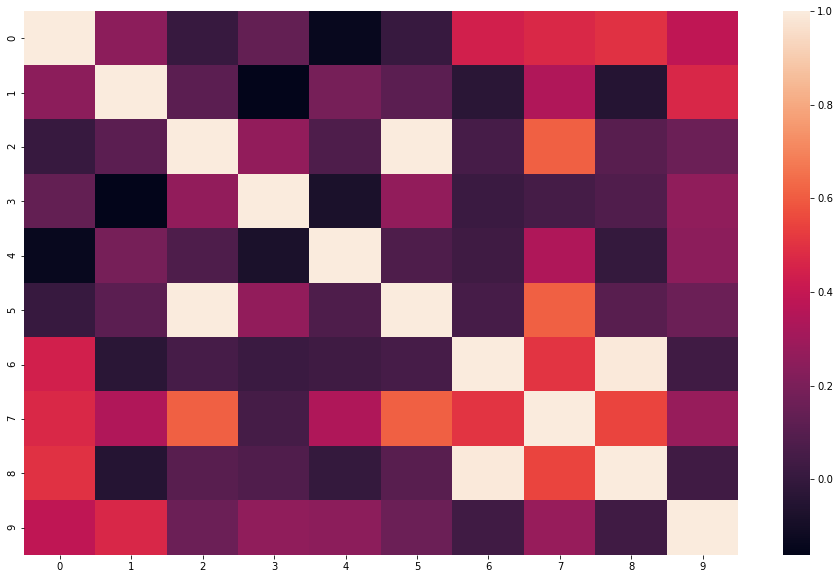

In [26]:
# 10개의 데이터를 가지고 시각적으로 표현해보겠습니다. 
corr2 = corr[:10, :10]
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

상관계수가 높으면 높을 수록 밝은 색의 히트맵이 나옵니다. 사용자의 선호도를 내포한 영화끼리의 상관계수를 구한 것 이므로, 특정 사용자가 좋아하는 영화끼리 높은 상관관계를 가지고 있을 것입니다

In [29]:
# 피어슨 상관 계수를 통해 얻은 결과로 '가디언즈 오브 갤럭시'와 비슷한 영화 10개를 뽑아봅니다.
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Guardians of the Galaxy (2014)")

corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:10]

['10,000 BC (2008)',
 '2 Guns (2013)',
 '2012 (2009)',
 '300: Rise of an Empire (2014)',
 'Abduction (2011)',
 'Adjustment Bureau, The (2011)',
 'Adventures of Tintin, The (2011)',
 'Alice in Wonderland (2010)',
 'Amazing Spider-Man, The (2012)',
 'Angels & Demons (2009)']

# 사용자 기반 협업 필터링

위에서는 하나의 영화에 대해서 비슷한 영화를 추천해주는 방법을 적용했습니다.  
그렇지만, 영화를 기준으로 추천을 받는 것 보단 나를 기준으로 추천을 받는게 더 좋은 방법일 것입니다.  
사용자에게 추천을 해주기 위해서 사용자 기반 협업 필터링 행렬 분해를 적용하겠습니다.  

In [30]:
rating_data = pd.read_csv('./data/movie_lens/ratings.csv')
movie_data = pd.read_csv('./data/movie_lens/movies.csv')

In [32]:
# 위와 같이 user-movie pivot table을 만들어줍니다. 
user_movie_ratings = rating_data.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

user_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# pivot table 값을 numpy matrix로 만듭니다.
matrix = user_movie_ratings.to_numpy()

# user의 평균 평점을 구합니다.
user_ratings_mean = np.mean(matrix, axis = 1)

# user-movie 데이터에 대해 user의 평균 평점을 빼줍니다.
matrix_diff_maen = matrix - user_ratings_mean.reshape(-1, 1)

여기서 평균 평점을 빼주는 이유는 각 user 마다 평점을 후하게 주는 사람 vs 평점을 짜게 주는 사람이 있기 때문입니다. 그래서 각 사용자의 평균을 빼준다면, 선호도를 확실히 알 수 있습니다. 

In [37]:
pd.DataFrame(matrix_diff_maen, columns = user_movie_ratings.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,...,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625
1,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,3.970770,...,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230
2,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,...,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075
3,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,3.902162,...,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838
4,-0.043128,-0.043128,3.956872,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,...,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128


## 특이값 분해

In [39]:
# scipy에서 제공해주는 Truncated SVD를 사용합니다.
# U 행렬, sigma 행렬, V 전치 행렬을 반환합니다.
U, sigma, Vt = svds(matrix_diff_maen, k = 12)

In [40]:
# Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현되어 있습니다. 
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(671, 12)
(12,)
(12, 9066)


In [47]:
# numpy의 diag를 이용해서 0이 포함된 대칭행렬로 변환합니다. 
sigma = np.diag(sigma)
sigma[: 4]

array([[105.72437051,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , 110.15522471,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        , 116.29714259,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 118.66831462,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

현재 까지 상황을 정리하면 아래와 같습니다.

- 원본 user-movie 평점 행렬이 있었음
- 이를 user의 평균 점수를 빼서 matrix_diff_maen 이라는 행렬로 만듬
- matrix_diff_maen의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
- Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환함.

In [50]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 됩니다. 
# 거기에 사용자 평균 rating을 더해주면 user가 예측한 평점이 나옵니다.
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [52]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = user_movie_ratings.columns)
df_svd_preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.079686,0.021779,-0.013837,-0.005870,-0.028877,0.032371,0.000715,-0.004428,-0.005219,0.038195,...,-0.004324,-0.004352,0.010478,-0.004256,-0.003944,-0.005674,0.018157,-0.005575,-0.005297,-0.003766
1,1.428452,1.608841,0.529476,0.168278,0.520809,1.107473,0.529719,0.089376,0.296270,1.970031,...,0.013227,-0.002275,0.020680,-0.005245,-0.007644,-0.021019,0.031243,-0.000957,-0.000753,0.026901
2,0.977246,0.396971,0.000299,0.027444,0.021287,0.141458,-0.057134,0.031633,-0.012538,0.383576,...,0.002761,0.004907,-0.014190,-0.000251,-0.006007,-0.003189,-0.026916,0.014637,0.013287,-0.005741
3,1.870844,1.169993,0.252202,0.094831,-0.181713,-0.511953,-0.027820,-0.143080,0.013247,1.461694,...,0.026412,-0.027245,0.054681,0.018450,0.034544,-0.035740,0.088889,-0.019365,-0.017113,0.066559
4,1.182777,0.924903,0.075998,0.061505,0.602680,-0.159825,0.339925,0.081534,-0.079666,0.535018,...,-0.029124,-0.029357,0.009064,-0.029092,-0.030890,-0.057453,0.026344,-0.024027,-0.024614,-0.032752


## 영화 추천 함수 만들기

In [61]:
def recommend_movies(df_svd_preds, user_id, origin_mv, origin_rt, num_recommend = 5):
    
    user_number = user_id - 1
    
    # user id에 따라서 영화 데이터가 평점 순으로 정렬
    sorted_user_pred = df_svd_preds.iloc[user_number].sort_values(ascending=False)
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑는다.
    user_data = origin_rt[origin_rt.userId == user_id]
    # user_data와 원본 영화 데이터를 합친다.
    user_history = user_data.merge(origin_mv, on = 'movieId').sort_values(['rating'], ascending=False)
    
    # 원본 영화 데이터에서 user가 본 영화를 제외한다.
    recommend = origin_mv[~origin_mv['movieId'].isin(user_history['movieId'])]
    # user의 영화 평점 순으로 정렬된 데이터와 recommend 데이터를 합친다.
    recommend = recommend.merge(pd.DataFrame(sorted_user_pred).reset_index(), on = 'movieId')
    # 컬럼 이름을 바꾸고 정렬해서 return
    recommend = recommend.rename(columns={user_number: 'Score'}).sort_values('Score', ascending=False).iloc[:num_recommend, :]
    
    return user_history, recommend

In [63]:
already_rated, predictions = recommend_movies(df_svd_preds, 200, movie_data, rating_data, 10)

In [64]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
65,200,2571,5.0,1437932708,"Matrix, The (1999)",Action|Sci-Fi|Thriller
47,200,1682,5.0,1437933004,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
34,200,1270,5.0,1437932711,Back to the Future (1985),Adventure|Comedy|Sci-Fi
45,200,1625,5.0,1437933483,"Game, The (1997)",Drama|Mystery|Thriller
166,200,36529,5.0,1437933015,Lord of War (2005),Action|Crime|Drama|Thriller|War
229,200,87522,4.5,1437933225,Larry Crowne (2011),Comedy|Drama|Romance
76,200,3408,4.5,1438021136,Erin Brockovich (2000),Drama
92,200,4226,4.5,1437933375,Memento (2000),Mystery|Thriller
91,200,4223,4.5,1437933190,Enemy at the Gates (2001),Drama|War
90,200,4161,4.5,1437933068,"Mexican, The (2001)",Action|Comedy


주로 선호하는 장르가 Action, Adventure, Drama 등등으로 보입니다.

In [65]:
predictions

,movieId,title,genres,Score
3760,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,3.385399
4271,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,3.301406
4884,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,3.255567
6689,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,2.907371
2781,3578,Gladiator (2000),Action|Adventure|Drama,2.734390
275,318,"Shawshank Redemption, The (1994)",Crime|Drama,2.441090
6716,59315,Iron Man (2008),Action|Adventure|Sci-Fi,2.246475
5979,33794,Batman Begins (2005),Action|Crime|IMAX,2.202902
7171,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,2.026921
501,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1.919666


가장 유력하게 추천되는 장르는 Adventure, Action, Fantasy 등등입니다. 위의 user_history 데이터와 비슷한 걸 보니 사용자 기반으로 잘 추천 된 것 같습니다. 